In [1]:
import os, math, random, argparse, ast, copy
from collections import Counter, defaultdict
from itertools import chain, combinations
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


### Local Imports

In [2]:
from utils.Spambase.split_data import split_data_equal
from utils.aggregate_functions import FederatedForest
from utils.evaluate_coalitions import evaluate_coalitions
from utils.DecisionTree import DecisionTree
from utils.Nash import find_nash_equilibria_v2
from utils.shapley_value import compute_and_visualize_shapley_values

# HuGaDB Dataset 

In [30]:
train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set and Preprocessing

In [31]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)

#### Centrelized Training


Confusion Matrix for Trial 1:
[[11465   221     0     1    51     3   780]
 [  175 11728     0     1    68     2   782]
 [    1     0  7552    21     0    20     1]
 [    0     0    46  1862    26     2     0]
 [   24    28     3    64 26401    52    98]
 [    1     7    70     1   124  2158     1]
 [ 1051   846     0     1   105     0 36458]]


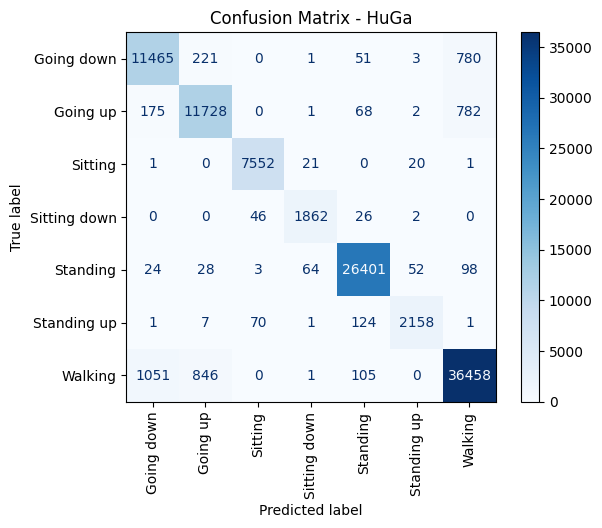

Trial 1 - Global test accuracy: 0.9542819718282324


In [6]:
# Parameters
trial= 1
n_trees = 10
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

    

model = RandomForestClassifier(n_estimators=n_trees, random_state=42 , max_depth=100)
model.fit(X_train_global, y_train_global)


y_pred = model.predict(X_test_global)
acc_test = accuracy_score(y_test_global, y_pred)


cm = confusion_matrix(y_test_global, y_pred)
print(f"\nConfusion Matrix for Trial {trial}:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f"Confusion Matrix - HuGa")
plt.show()


results_global.append(acc_test)

print(f"Trial {trial} - Global test accuracy: {acc_test}")


df_global = pd.DataFrame(results_global, columns=["accuracy"])
df_global.to_csv("global.csv", index=False)


## Federated Learning (FedFor) _ without low-quality clients _ HuGaDB

In [23]:
# Parameters
max_depth = 100
n_clients = 10 
n_trials = 1
random_seed = 43

results = []


for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the 10 clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []
    for i in range(n_clients):
        df_train_i = pd.read_csv(f"/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i+1:02d}.csv").dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_train, y_train)
        client_models.append(model)

        # Test locally
        df_test_i = pd.read_csv(f"/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i+1:02d}.csv").dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate globally
        y_pred_global = model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy
        y_pred_global = forest.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

df_results = pd.DataFrame(results)
df_results.to_csv("HuGa_results_with_FedFor.csv", index=False)


Trial 1/1


In [8]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42
max_depth = 100
results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    client_models = []
    client_global_accuracies = []

    for i in range(n_clients):
        # Load client-specific training data
        df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed)
        model.fit(scaler.fit_transform(X_train), y_train)
        client_models.append(model)

        # Evaluate globally
        y_pred_global = model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all coalitions using the helper function
    df_trial_results = evaluate_coalitions(
        client_models=client_models,
        client_global_accuracies=client_global_accuracies,
        n_clients=n_clients,
        aggregator_func=FederatedForest,
        X_test=X_test_global_scaled,
        y_test=y_test_global,
        corrupt_client_indices=[], 
        approach='fedfor'
    )
    df_trial_results['Trial'] = trial + 1
    results.append(df_trial_results)

# Combine and save
df_results = pd.concat(results, ignore_index=True)


save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedFor_HuGaDB_without_LQC"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "HuGaDB_results_with_FedFor.csv")
df_results.to_csv(save_path, index=False)


Trial 1/1


In [12]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy,Trial
1022,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.894654,0.605703,0.494462,0.647306,0.685888,0.731283,0.594041,0.762475,0.706484,0.713209,0.693258,1
1020,1111111101,"[1, 3, 4, 5, 6, 7, 8, 9, 10]",0.893491,0.605703,0.494462,0.647306,0.685888,0.731283,0.594041,0.762475,0.706484,0.713209,0.693258,1
988,1111011101,"[1, 3, 4, 5, 7, 8, 9, 10]",0.891819,0.605703,0.494462,0.647306,0.685888,0.731283,0.594041,0.762475,0.706484,0.713209,0.693258,1
990,1111011111,"[1, 2, 3, 4, 5, 7, 8, 9, 10]",0.890783,0.605703,0.494462,0.647306,0.685888,0.731283,0.594041,0.762475,0.706484,0.713209,0.693258,1
1016,1111111001,"[1, 4, 5, 6, 7, 8, 9, 10]",0.888271,0.605703,0.494462,0.647306,0.685888,0.731283,0.594041,0.762475,0.706484,0.713209,0.693258,1


In [13]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy,Trial
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.894654,1


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.762475                  0.128826
4   Client 5        0.731283                  0.125571
7   Client 8        0.706484                  0.115908
3   Client 4        0.685888                  0.111887
8   Client 9        0.713209                  0.111072
9  Client 10        0.693258                  0.104727
2   Client 3        0.647306                  0.089741
0   Client 1        0.605703                  0.086291
5   Client 6        0.594041                  0.069459
1   Client 2        0.494462                  0.056518


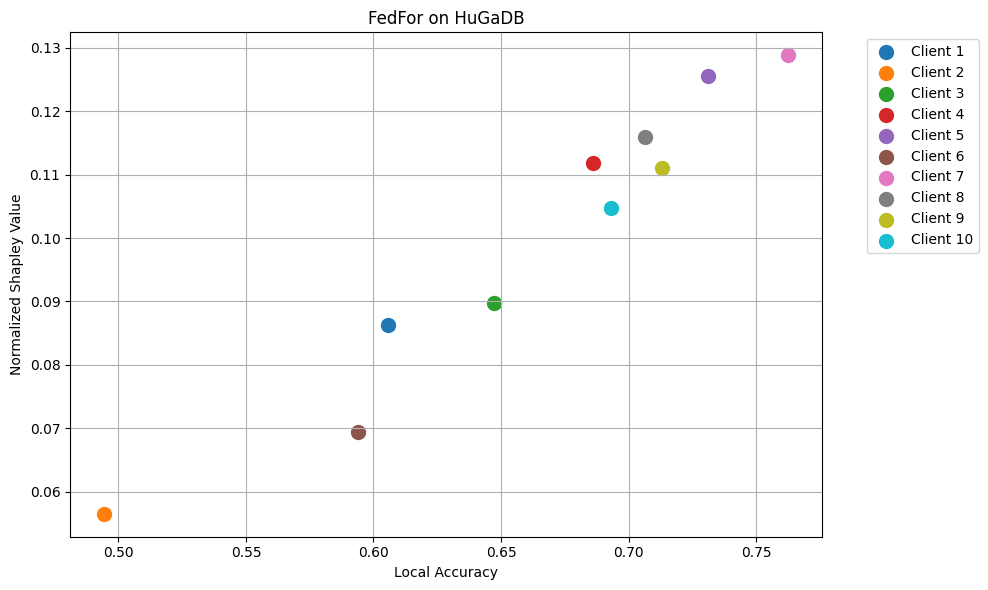

In [14]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedFor on HuGaDB",  
    print_df=True 
)


#### Evaluating Grand coalition as a Nash Eq For HuGaDB in 350 number of samples for each client and different Max_depth Without LQC

In [32]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [33]:
# File patterns.
train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv"
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv"

# Concatenate all training files.
df_train_global = pd.concat([
    pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)
]).dropna()

# Concatenate all testing files.
df_test_global = pd.concat([
    pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)
]).dropna()

# Split features and labels.
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels.
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features.
scaler_global = StandardScaler()
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled  = scaler_global.transform(X_test_global)
# Create a stratified subsample of the test set to speed up the runtime.
subsample_size = 950  
X_test_global_scaled, _, y_test_global, _ = train_test_split(
    X_test_global_scaled, y_test_global,
    train_size=subsample_size,
    random_state=42,
    stratify=y_test_global
)
print("Subsampled test set shape:", X_test_global_scaled.shape)

Subsampled test set shape: (950, 38)


In [34]:
# Parameters
n_clients = 10
n_trials = 50
base_random_seed = 42
max_depths = [10, 100]
sample_size = 350
approach = 'fedfor'

# Saving directory
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedFor_HuGaDB_without_LQC/evaluate_grand_combination_without_LQC"
os.makedirs(save_dir, exist_ok=True)

train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv"
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv"

all_details = []


for max_depth in max_depths:
    print(f"\nRunning experiment: max_iter={max_depth}")
    nash_counts = Counter()
    details_for_this_param = []
    client_accuracy_details = []

    for trial in range(n_trials):

        rand_component = random.randint(0, 500)
        trial_seed = base_random_seed + trial + int(1000 * max_depth) + 2 * rand_component
        random.seed(trial_seed)
        np.random.seed(trial_seed)


        client_models = []
        client_global_accuracies = {}

        for client_idx in range(n_clients):
            df_train_local = pd.read_csv(train_files_pattern.format(i=client_idx + 1)).dropna(subset=['act'])

            
            df_train_local, _ = train_test_split(
                df_train_local,
                train_size=sample_size,
                random_state=trial_seed,
                stratify=df_train_local['act']
            )


            df_train_local = df_train_local.reset_index(drop=True).dropna()
            y_train_local = label_encoder.transform(df_train_local['act'])
            X_train_local = df_train_local.drop('act', axis=1).values
            X_train_local_scaled = scaler.transform(X_train_local)


            model = DecisionTree(max_depth=max_depth, random_state=trial_seed)
            model.fit(X_train_local_scaled, y_train_local)
            client_models.append(model)


            y_pred_global = model.predict(X_test_global_scaled)
            acc_global = accuracy_score(y_test_global, y_pred_global)
            client_global_accuracies[client_idx] = acc_global

        # --- Evaluate all model coalitions ---
        df_results = evaluate_coalitions(
            client_models=client_models,
            client_global_accuracies=client_global_accuracies,
            n_clients=n_clients,
            aggregator_func=FederatedForest,
            X_test=X_test_global_scaled,
            y_test=y_test_global,
            corrupt_client_indices=[],
            approach=approach
        )
        df_results['Trial'] = trial + 1
        df_results['Max Iter or Depth'] = max_depth

        # --- Find Nash Equilibria ---
        df_nash = find_nash_equilibria_v2(df_results.reset_index())
        for coalition in df_nash['Combination']:
            nash_counts[coalition] += 1

        df_nash['Trial'] = trial + 1
        df_nash['Max Iter or Depth'] = max_depth
        details_for_this_param.append(df_nash)

        # --- Client Accuracies ---
        trial_acc = {
            'Trial': trial + 1,
            'Max Iter or Depth': max_depth
        }
        for j in range(n_clients):
            trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
        client_accuracy_details.append(trial_acc)

    # --- Save Nash count summary ---
    df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Iter or Depth'] = max_depth
    filename_counts = os.path.join(save_dir, f"Nash_Equilibrium_Counts_{approach}_maxdepth_{max_depth}.csv")
    df_nash_counts.to_csv(filename_counts, index=False)

    # --- Merge and save trial details ---
    df_details = pd.concat(details_for_this_param, ignore_index=True)
    df_client_accuracy = pd.DataFrame(client_accuracy_details)
    df_combined = df_details.merge(
        df_client_accuracy,
        on=['Trial', 'Max Iter or Depth'],
        how='left'
    )
    all_details.append(df_combined)

# --- Save full merged results ---
final_details_df = pd.concat(all_details, ignore_index=True)
details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}.csv")
final_details_df.to_csv(details_path, index=False)


Running experiment: max_iter=10

Running experiment: max_iter=100


# Spambase Dataset

In [16]:
file_path = '/Users/abbaszal/Documents/Thesis_Project_Spambase/data/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Creating Global Train set and Test set and Preprocessing

In [17]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Centrelized Training


Confusion Matrix for Trial 1:
[[521  10]
 [ 45 345]]


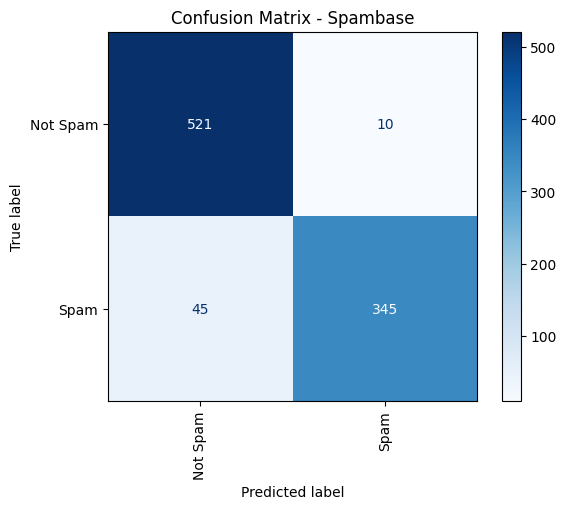

Trial 1 - Global test accuracy: 0.9402823018458197


In [29]:
# Parameters
trial = 1  
n_trees = 10  
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

model = RandomForestClassifier(n_estimators=n_trees, random_state=42 , max_depth=100)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix for Trial {trial}:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f"Confusion Matrix - Spambase")
plt.show()


results_global.append(acc_test)
print(f"Trial {trial} - Global test accuracy: {acc_test}")


## Federated Learning (FedFor) _ without low-quality clients _ Spambase

In [19]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [20]:
def train_models_fedfor(partitions, X_test, y_test, max_depth):
    client_models = []
    client_global_accuracies = {}
    
    for i, (X_i, y_i) in enumerate(partitions):
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=np.random.randint(0, 100000))
        model.fit(X_i, y_i)
        client_models.append(model)
        y_pred = model.predict(X_test)
        client_global_accuracies[i] = np.mean(y_pred == y_test)  # equivalent to accuracy_score
    return client_models, client_global_accuracies

In [22]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42
max_depth = 100

results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    # Train client models
    client_models, client_global_accuracies = train_models_fedfor(
        partitions, X_test, y_test, max_depth
    )

    # Evaluate all coalitions using the helper function
    df_trial_results = evaluate_coalitions(
        client_models=client_models,
        client_global_accuracies=client_global_accuracies,
        n_clients=n_clients,
        aggregator_func=FederatedForest,
        X_test=X_test,
        y_test=y_test,
        corrupt_client_indices=[],  
        approach='fedfor'
    )
    df_trial_results['Trial'] = trial + 1
    results.append(df_trial_results)


df_results = pd.concat(results, ignore_index=True)


save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedFor_Spambase_without_LQC"
os.makedirs(save_dir, exist_ok=True)


save_path = os.path.join(save_dir, "Spambase_results_with_FedFor.csv")
df_results.to_csv(save_path, index=False)

Trial 1/1


In [23]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy,Trial
931,1110100100,"[3, 6, 8, 9, 10]",0.923996,0.871878,0.856678,0.850163,0.846906,0.858849,0.875136,0.857763,0.868621,0.863192,0.875136,1
972,1111001101,"[1, 3, 4, 7, 8, 9, 10]",0.923996,0.871878,0.856678,0.850163,0.846906,0.858849,0.875136,0.857763,0.868621,0.863192,0.875136,1
700,1010111101,"[1, 3, 4, 5, 6, 8, 10]",0.922910,0.871878,0.856678,0.850163,0.846906,0.858849,0.875136,0.857763,0.868621,0.863192,0.875136,1
940,1110101101,"[1, 3, 4, 6, 8, 9, 10]",0.921824,0.871878,0.856678,0.850163,0.846906,0.858849,0.875136,0.857763,0.868621,0.863192,0.875136,1
1020,1111111101,"[1, 3, 4, 5, 6, 7, 8, 9, 10]",0.921824,0.871878,0.856678,0.850163,0.846906,0.858849,0.875136,0.857763,0.868621,0.863192,0.875136,1


In [24]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy,Trial
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.915309,1


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.868621                  0.105063
9  Client 10        0.875136                  0.103933
0   Client 1        0.871878                  0.103411
2   Client 3        0.850163                  0.101056
5   Client 6        0.875136                  0.101037
8   Client 9        0.863192                  0.098724
3   Client 4        0.846906                  0.097545
4   Client 5        0.858849                  0.097162
6   Client 7        0.857763                  0.096582
1   Client 2        0.856678                  0.095487


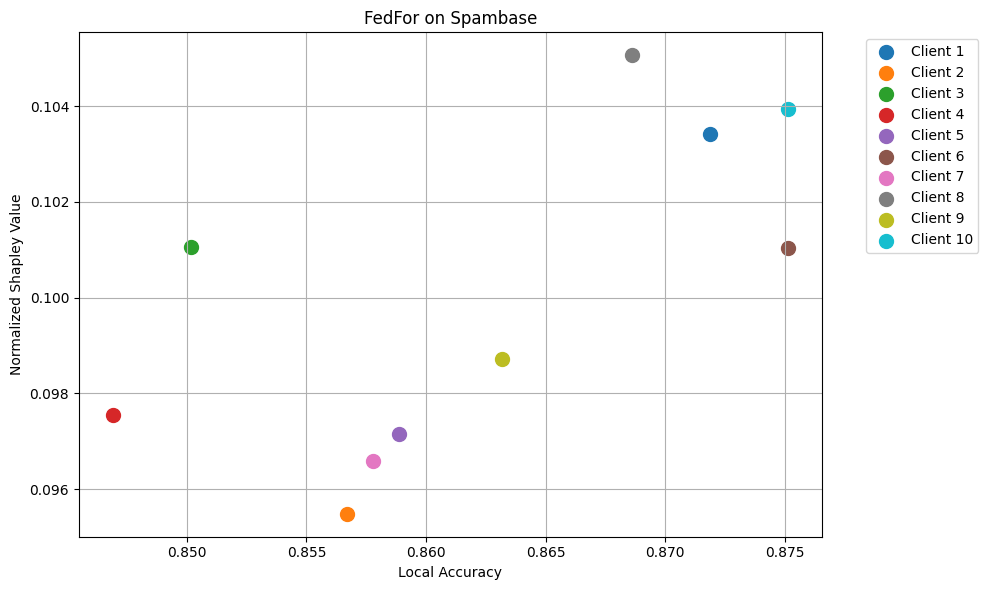

In [25]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedFor on Spambase",  
    print_df=True 
)


#### Evaluating Grand coalition as a Nash Eq For Spambase in different Max_depth Without LQC

In [26]:
random_seed= 42
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
n_trials = 50
n_clients = 10
base_random_seed = 42
max_depths = [10, 100]
approach = 'fedfor'


# Prepare saving directory
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedFor_Spambase_without_LQC/evaluate_grand_combination_without_LQC"
os.makedirs(save_dir, exist_ok=True)

all_details = []

for max_depth in max_depths:
    print(f"\nRunning experiment for max_iter = {max_depth}")
    nash_counts = Counter()
    details_for_this_param = []
    client_accuracy_details = []

    for trial in range(n_trials):

        # Set seed
        rand_component = random.randint(0, 500)
        trial_seed = base_random_seed + trial + int(1000 * max_depth) + 2 * rand_component

        # Partition client data
        partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True , random_seed= trial_seed)

        # Train federated models
        client_models, client_global_acc = train_models_fedfor(
            partitions=partitions,
            X_test=X_test,
            y_test=y_test,
            max_depth=max_depth
        )

        # Evaluate all coalitions
        df_results = evaluate_coalitions(
            client_models=client_models,
            client_global_accuracies=client_global_acc,
            n_clients=n_clients,
            aggregator_func=FederatedForest,
            X_test=X_test,
            y_test=y_test,
            corrupt_client_indices=[],
            approach=approach
        )
        df_results['Trial'] = trial + 1
        df_results['Max Iter or Depth'] = max_depth


        df_nash = find_nash_equilibria_v2(df_results.reset_index())
        for coalition in df_nash['Combination']:
            nash_counts[coalition] += 1
        df_nash['Trial'] = trial + 1
        df_nash['Max Iter or Depth'] = max_depth
        details_for_this_param.append(df_nash)


        trial_acc = {
            'Trial': trial + 1,
            'Max Iter or Depth': max_depth,
        }
        for j in range(n_clients):
            col_name = f'Client {j+1} Accuracy'
            trial_acc[col_name] = client_global_acc[j] if client_global_acc[j] is not None else np.nan
        client_accuracy_details.append(trial_acc)

    # Save Nash count summary
    df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Iter or Depth'] = max_depth
    filename_counts = os.path.join(save_dir, f"Nash_Equilibrium_Counts_{approach}_maxdepth_{max_depth}.csv")
    df_nash_counts.to_csv(filename_counts, index=False)

    # Merge trial-wise Nash + client accuracy details
    df_details = pd.concat(details_for_this_param, ignore_index=True)
    df_client_accuracy = pd.DataFrame(client_accuracy_details)
    df_combined = df_details.merge(
        df_client_accuracy,
        on=['Trial', 'Max Iter or Depth'],
        how='left'
    )
    all_details.append(df_combined)

final_details_df = pd.concat(all_details, ignore_index=True)
details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}.csv")
final_details_df.to_csv(details_path, index=False)



Running experiment for max_iter = 10

Running experiment for max_iter = 100
